# How to analyse multi-ensemble data with ``pyemma.thermo``?

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pyemma
from pyemma.datasets import get_multi_temperature_data, get_umbrella_sampling_data

ImportError: No module named matplotlib

## Multi-temperature simulations

When simulating at multiple temperatures, we define bias energies relative to a selected reference temperature:

$$b^{(i)}(\mathbf{x}) = \left( \frac{1}{\text{k}_\text{B} T^{(i)}} - \frac{1}{\text{k}_\text{B} T^{\circ}} \right) U(\mathbf{x}) = \left( \frac{1}{\text{k}_\text{B} T^{(i)}} - \frac{1}{\text{k}_\text{B} T^{\circ}} \right) \text{k}_\text{B} T^{(j)} u^{(j)}(\mathbf{x})$$

The ``get_multi_temperature_data()`` function from ``pyemma.datasets`` generates independent trajectories at two different temperatures for a 1D asymmetric double well potential.

In [2]:
with np.load('multi_temperature_data.npz') as npz:
    mt_data = {k:npz[k] for k in npz.keys()}
    mt_data['dtrajs'] = list(mt_data['dtrajs'])
print('Available keys: ' + str(mt_data.keys()))

Available keys: dict_keys(['dtrajs', 'trajs', 'temp_trajs', 'centers', 'energy_trajs'])


How much data do we have?

In [4]:
print('Number of trajectories:' , len(mt_data['trajs']))
print('Length of each trajectory:' , mt_data['trajs'][0].size)

Number of trajectories: 20
Length of each trajectory: 10001


Each trajectory is simulated at a fixed temperature, the temperatures are given in multiple of kT, 10 at 1 kT and 10 at 5 kT:

In [6]:
for i in range(20): 
    print(mt_data['temp_trajs'][i][0])

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


Indeed the lower-temperature trajectories displays less transitions than the higher-temperature ones:

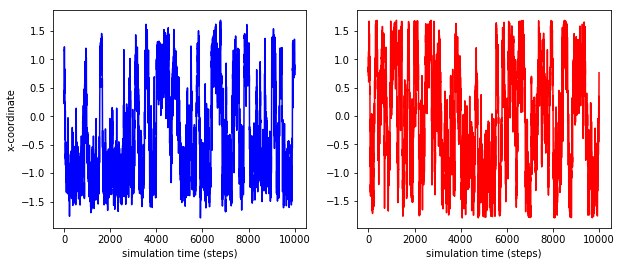

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(mt_data['trajs'][7], color='blue')
axes[0].set_xlabel('simulation time (steps)')
axes[0].set_ylabel('x-coordinate')
axes[1].plot(mt_data['trajs'][17], color='red')
axes[1].set_xlabel('simulation time (steps)')

We also have energy trajectories, that nicely show the existence of two metastable sets

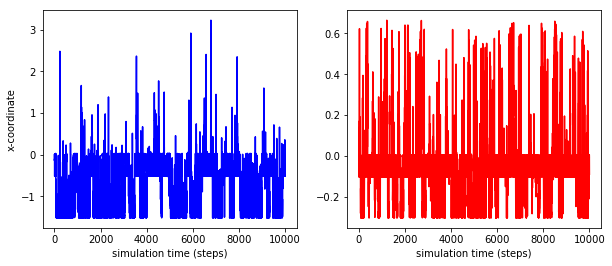

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(mt_data['energy_trajs'][7], color='blue')
axes[0].set_xlabel('simulation time (steps)')
axes[0].set_ylabel('x-coordinate')
axes[1].plot(mt_data['energy_trajs'][17], color='red')
axes[1].set_xlabel('simulation time (steps)')

Finally, we have the discretization of the simulation trajectories `dtrajs` and the x-`centers` corresponding to the discrete states (just needed for plotting)

### Estimation

PyEMMA's thermo package offers a convenient API function to compute the bias energies for this type of simulation and perform a WHAM, MBAR, DTRAM or TRAM estimation:

```python
def estimate_multi_temperature(
    energy_trajs, temp_trajs, dtrajs,
    energy_unit='kcal/mol', temp_unit='K', reference_temperature=None,
    maxiter=10000, maxerr=1.0E-15, save_convergence_info=0,
    estimator='wham', lag=1, dt_traj='1 step',
    init=None, init_maxiter=10000, init_maxerr=1.0E-8, **kwargs):
    ...
```

Let's use ``estimate_multi_temperature()`` with our data. By default, the function performs a WHAM calculation

In [9]:
mt_wham = pyemma.thermo.estimate_multi_temperature(
    mt_data['energy_trajs'],
    mt_data['temp_trajs'],
    mt_data['dtrajs'],
    estimator='wham',
    energy_unit='kT',
    temp_unit='kT')

In [44]:
mt_wham.

SyntaxError: invalid syntax (<ipython-input-44-d81d564e2abf>, line 1)

Now we can plot the potential of mean force and stationary distribution estimate for the unbiased thermodynamic state, i.e., at the reference temperature which defaults to the lowest in the provided set:

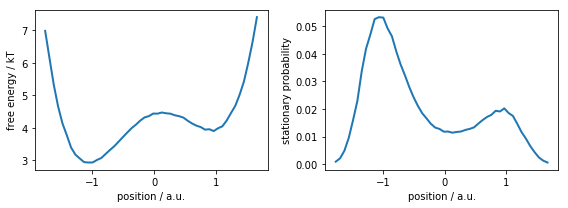

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].plot(mt_data['centers'], mt_wham.f, linewidth=2)
axes[0].set_ylabel('free energy / kT')
axes[1].plot(mt_data['centers'], mt_wham.pi, linewidth=2)
axes[1].set_ylabel('stationary probability')
for ax in axes.flat:
    ax.set_xlabel('position / a.u.')
fig.tight_layout()

Besides these properties for the unbiased thermodynamic state, a multi-ensemble estimator object contains a model for each individual thermodynamic state in the input. Let's have a look:

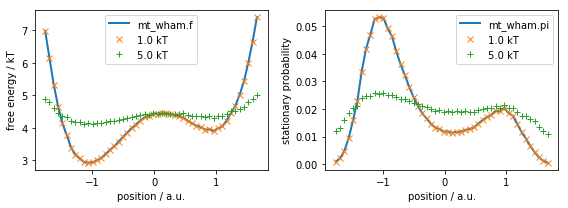

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].plot(mt_data['centers'], mt_wham.f, linewidth=2, label='mt_wham.f')
axes[1].plot(mt_data['centers'], mt_wham.pi, linewidth=2, label='mt_wham.pi')
for i, (model, marker) in enumerate(zip(mt_wham.models, ['x', '+'])):
    axes[0].plot(mt_data['centers'], model.f, marker, label='%.1f kT' % mt_wham.temperatures[i])
    axes[1].plot(mt_data['centers'], model.pi, marker, label='%.1f kT' % mt_wham.temperatures[i])
axes[0].set_ylabel('free energy / kT')
axes[1].set_ylabel('stationary probability')
for ax in axes.flat:
    ax.set_xlabel('position / a.u.')
    ax.legend()
fig.tight_layout()

Now, we use ``estimate_multi_temperature()`` with ``dtram`` at a selction of lag times, and we plot the convergence behaviour as well the the implied timescales for both thermodynamic states:

In [12]:
mt_memm = pyemma.thermo.estimate_multi_temperature(
    mt_data['energy_trajs'],
    mt_data['temp_trajs'],
    mt_data['dtrajs'],
    energy_unit='kT', temp_unit='kT', reference_temperature=1.0,
    maxiter=10000, maxerr=1e-15, save_convergence_info=10,
    estimator='dtram', lag=[1, 2, 5, 10, 20, 50, 100])

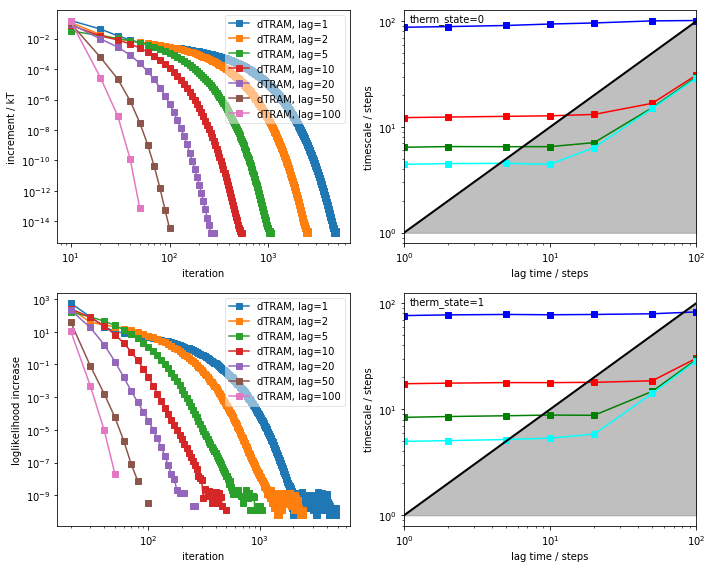

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
pyemma.plots.plot_convergence_info(mt_memm, axes=axes[:, 0])
for i, ax in enumerate(axes[:, 1].flat):
    pyemma.plots.plot_memm_implied_timescales(
        mt_memm, therm_state=i, ax=ax, xlog=True, nits=4, marker='s')
fig.tight_layout()

In [22]:
mt_memm[0]

DTRAM(bias_energies_full=array([[  8.88178e-16,  -8.88178e-16, ...,   8.88178e-16,   0.00000e+00],
       [ -2.09341e+00,  -1.34297e+00, ...,  -1.75435e+00,  -2.40272e+00]]),
   connectivity='reversible_pathways', count_mode='sliding',
   dt_traj='1 step', init=None, init_maxerr=1e-08, init_maxiter=10000,
   lag=1, maxerr=1e-15, maxiter=10000, save_convergence_info=10)

### Analysis of a selected MEMM

Let's choose the MEMM at lag time $\tau$=1 step and focus on the unbiased thermodynamic state, which is, in this case, corresponding to the heat bath temperature we selected as ``reference_temperature``. The MEMM provides the attribute ``mt_memm.msm`` which points to the corresponding ``MSM`` object in the ``mt_memm.models`` list.

In [23]:
mt_msm = mt_memm[0].msm

We start our analysis by plotting the kT=1.0 free energy profile against the discrete states' centers, which we separate into two metastable sets using ``PCCA++``:

In [ ]:
mt_msm.f

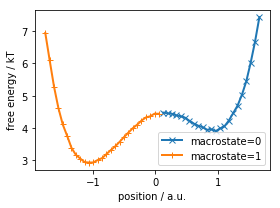

In [15]:
mt_msm.pcca(2)
fig, ax = plt.subplots(figsize=(4, 3))
for i, (s, marker) in enumerate(zip(mt_msm.metastable_sets, ['-x', '-+'])):
    ax.plot(mt_data['centers'][s], mt_msm.free_energies[s], marker, linewidth=2, label='macrostate=%d' % i)
ax.set_xlabel('position / a.u.')
ax.set_ylabel('free energy / kT')
ax.legend()
fig.tight_layout()

We can compute thermodynamic properties of the two metastable states, e.g., their stationary probabilities:

In [16]:
for i, s in enumerate(mt_msm.metastable_sets):
    print('PI[%d] = %.3f' % (i, mt_msm.pi[s].sum()))

PI[0] = 0.283
PI[1] = 0.717


We can compute kinetic properties as well, e.g., the mean first passage times (MFPTs) between the two metastable sets:

In [17]:
for i, a in enumerate(mt_msm.metastable_sets):
    for j, b in enumerate(mt_msm.metastable_sets):
        if i == j:
            continue
        print('MFPT[%d,%d] = %3.0f steps' % (i, j, mt_msm.mfpt(a, b)))

MFPT[0,1] =  62 steps
MFPT[1,0] = 178 steps


In [21]:
mt_msm

### What else?

* Convince yourself the unbiased stationary distribution of the dTRAM estimator, ``memm.pi``, and the stationary distribution of the highlighted model, ``memm.msm.pi``, are identical.
* ``memm.msm`` is a convenient shortcut to our reference state model ``memm.models[0]``. You can also examine the biased thermodynamic state's kinetics using ``memm.models[1]``, which is also an ``MSM`` object.
* A different estimator might perform better or worse. Find out what happens if you use ``estimator='mbar'`` or ``estimator='tram'``.
* Here, we used trajectories where the heat bath temperature did not change within trajectories. Run a simulated/parallel tempering simluation where the ``temp_trajs`` are not constant anymore.

## Umbrella sampling

We assume that the bias is computed via a harmonic potential based on the deviation of a frame from a reference structure. In the usual one-dimensional case, this reads

$$b^{(i)}(\mathbf{x}) = \frac{k^{(i)}}{2} \left\Vert \mathbf{x} - \mathbf{x}^{(i)} \right\Vert^2.$$

In the more general case, though, one can use a non-symmetric force matrix:

$$b^{(i)}(\mathbf{x}) = \frac{1}{2} \left\langle \mathbf{x} - \mathbf{x}^{(i)} \middle\vert \mathbf{k}^{(i)} \middle\vert \mathbf{x} - \mathbf{x}^{(i)} \right\rangle.$$

The ``get_umbrella_sampling_data()`` function from ``pyemma.datasets`` generates independent umbrella sampling as well as unbiased trajectories for a 1D asymmetric double well potential.

PyEMMA's API function for this type of simulation is:

```python
def estimate_umbrella_sampling(
    us_trajs, us_dtrajs, us_centers, us_force_constants,
    md_trajs=None, md_dtrajs=None, kT=None,
    maxiter=10000, maxerr=1.0E-15, save_convergence_info=0,
    estimator='wham', lag=1, dt_traj='1 step',
    init=None, init_maxiter=10000, init_maxerr=1.0E-8, **kwargs):
    ...

```

### Exercise!

Now comes the practical part and it is up to you to setup the anaylsis. As a rough guide, you should

1. familiarise yourself with the data from ``get_umbrella_sampling_data()``,
2. familiarise yourself with the API function ``estimate_umbrella_sampling()``,
3. estimate ``MEMM``s at different lag times,
4. and visualise/compute thermodynamic and kinetic properties like we did for the multi-temperature case.

### What else?

* What happens when ``md_trajs=None`` and ``md_dtrajs=None``?
* How do dTRAM and WHAM compare with/without unbiased data available?

**Good luck and have fun!**

In [18]:
us_data = get_umbrella_sampling_data()
print('Available keys: ' + str(us_data.keys()))

TypeError: unsupported operand type(s) for +: 'map' and 'float'